In [50]:
%load_ext autoreload
%autoreload 2

from src.models.wifi_model import WifiModel
from src.data.datasets import FloorDataset
from src.utils import object_to_markdown

from IPython.display import display

import seaborn as sns
import matplotlib.pyplot as plt
import torch

site_id = "5d2709b303f801723c327472"
floor_id = "1F"

floor_data = FloorDataset(site_id, floor_id, wifi_threshold=400, sampling_interval=100, include_wifi=True, include_beacon=False,        validation_percent=0.3,
        test_percent=0.2)
sns.set(style="whitegrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Wifi Model

In the initial model, we are only looking at including the wifi signals of the model. We have implemented the model in `src/models/initial_model.py` as a method of the `InitialModel` class which also holds various model attributes and the variational parameters. The source code of the generative model can be seen below:

In [51]:
display(object_to_markdown(WifiModel.model))

```python
def model(
    self,
    mini_batch_index,
    mini_batch_length,
    mini_batch_time,
    mini_batch_position,
    mini_batch_position_mask,
    mini_batch_wifi,
    mini_batch_wifi_mask,
    annealing_factor=1.0,
):

    pyro.module("initial_model", self)

    T_max = mini_batch_time.shape[-1]
    K = self.K

    relaxed_floor_dist = dist.Normal(
        self.floor_uniform.mean, self.floor_uniform.stddev
    ).to_event(1)

    sigma_eps = torch.tensor(self.prior_params["sigma_eps"], device=device)
    sigma = torch.tensor(self.prior_params["sigma"], device=device)
    mu_omega_0 = torch.tensor(self.prior_params["mu_omega_0"], device=device)
    sigma_omega_0 = torch.tensor(self.prior_params["sigma_omega_0"], device=device)
    sigma_omega = torch.tensor(self.prior_params["sigma_omega"], device=device)

    with poutine.scale(None, annealing_factor):

        with pyro.plate("mini_batch", len(mini_batch_index)):

            x_0 = sample("x_0", relaxed_floor_dist)
            x = torch.zeros(
                x_0.shape[:-1] + (T_max,) + x_0.shape[-1:],  # Batch dims, time, x/y
                dtype=mini_batch_position.dtype,
                device=device,
            )
            x[..., 0, :] = x_0

            for t in pyro.markov(range(1, T_max)):
                x[..., t, :] = sample(
                    f"x_{t}",
                    dist.Normal(x[..., t - 1, :], sigma_eps)
                    .to_event(1)
                    .mask(t < mini_batch_length),
                )

    with pyro.plate("x_observed", mini_batch_position_mask.sum()):
        sample(
            "x_hat",
            dist.Normal(x[..., mini_batch_position_mask, :], sigma).to_event(1),
            obs=mini_batch_position[mini_batch_position_mask],
        )

    any_wifi_is_observed = mini_batch_wifi_mask.any(dim=-1)

    with plate("wifis", K):

        with poutine.scale(None, annealing_factor):
            omega_0 = sample("omega_0", dist.Normal(mu_omega_0, sigma_omega_0))
            wifi_location = sample("wifi_location", relaxed_floor_dist)

        distance = torch.cdist(x[..., any_wifi_is_observed, :], wifi_location)
        with plate("wifi_is_observed", any_wifi_is_observed.sum()):
            signal_strength = omega_0 - 2 * torch.log(distance)
            omega = sample(
                "omega",
                dist.Normal(signal_strength, sigma_omega).mask(
                    mini_batch_wifi_mask[any_wifi_is_observed]
                ),
                obs=mini_batch_wifi[any_wifi_is_observed],
            )

    return x, wifi_location
```

tensor([  1,   4,   6,   8,  10,  11,  14,  15,  23,  26,  28,  29,  30,  32,
         33,  35,  37,  41,  42,  44,  46,  47,  50,  51,  53,  55,  56,  57,
         59,  60,  62,  64,  65,  68,  70,  71,  72,  73,  74,  76,  77,  78,
         81,  83,  86,  90,  91,  94,  96,  98,  99, 100, 102, 103, 106, 110,
        112, 113, 114, 115, 118, 120, 121, 122, 124, 125, 130, 131, 134, 135,
        136, 138, 139, 140, 141, 142, 144, 145, 147, 148, 149, 151, 152, 155,
        158, 161, 163, 165, 166, 168, 170, 171, 172, 174, 176, 177, 178, 179,
        183, 185, 186, 188, 190, 191, 193, 195, 197, 198, 199, 200, 202, 203,
        205, 206, 207, 208, 209, 210, 214, 215, 220, 221, 222, 224, 225, 226,
        227, 228, 229, 230, 232, 234, 235, 239])

In [52]:
train_indices = (~floor_data.test_mask & ~floor_data.validation_mask).nonzero().flatten()
validation_indices = floor_data.validation_mask.nonzero().flatten()

mini_batch_train = floor_data[train_indices[0:8]]
mini_batch_validation = floor_data[validation_indices[0:8]]

In [53]:
torch.manual_seed(123)
wifi_model = WifiModel(floor_data)

## Model Training
Due to the size of the model / the number of parameters, the model is trained using the `src/models/initial_models.py` script. This allowed us to easily use the DTU HPC cluster for training. Below, we load a checkpoint of the trained model

In [54]:
checkpoint = torch.load("../checkpoints/wifi-model.pt", map_location="cpu")
wifi_model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

We can investigate the training loss over the course of training the model

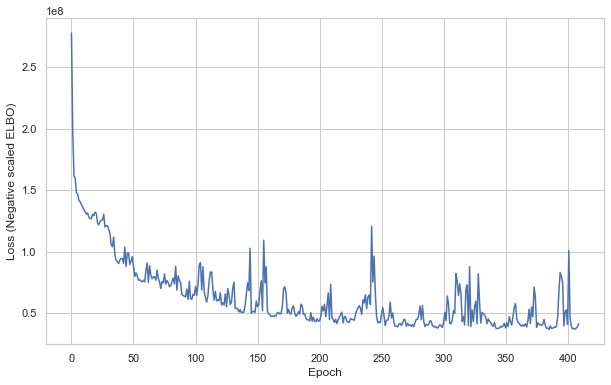

In [55]:
plt.figure(figsize=(10,6))
plt.plot(checkpoint["loss_history"])
plt.xlabel("Epoch")
plt.ylabel("Loss (Negative scaled ELBO)")

plt.show()

In [56]:
def plot_traces(model, mini_batch):

    plt.figure(figsize=(10,10))

    mini_batch_index = mini_batch[0]
    mini_batch_length = mini_batch[1]
    mini_batch_position = mini_batch[3]
    mini_batch_position_mask = mini_batch[4]

    with torch.no_grad():
        loc_q, scale_q = wifi_model.guide(*mini_batch)
        loc_q[loc_q==0] = float("nan")

    for i in range(len(mini_batch_index)):
        x_hat = mini_batch_position[i, mini_batch_position_mask[i], :]
        
        plt.plot(*x_hat.T, "-o", color=f"C{i}")
        plt.plot(*loc_q[i].T, linestyle="--", color=f"C{i}")

        for j in range(100, mini_batch_length[i], 50):
            plt.plot(*loc_q[i, j, :], "x", color=f"C{i}")
            plt.gca().add_patch(plt.Circle(loc_q[i, j, :], scale_q[i].sqrt(), fill=False, color=f"C{i}"))
    
    plt.axis("equal")

plt.show()

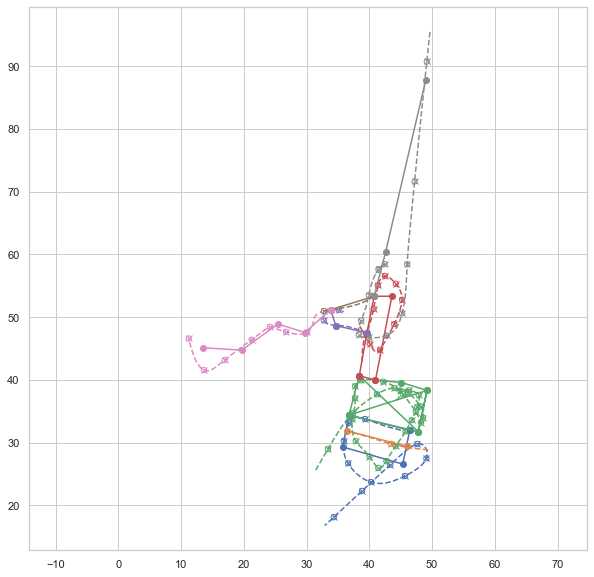

In [57]:
plot_traces(wifi_model, mini_batch_train)

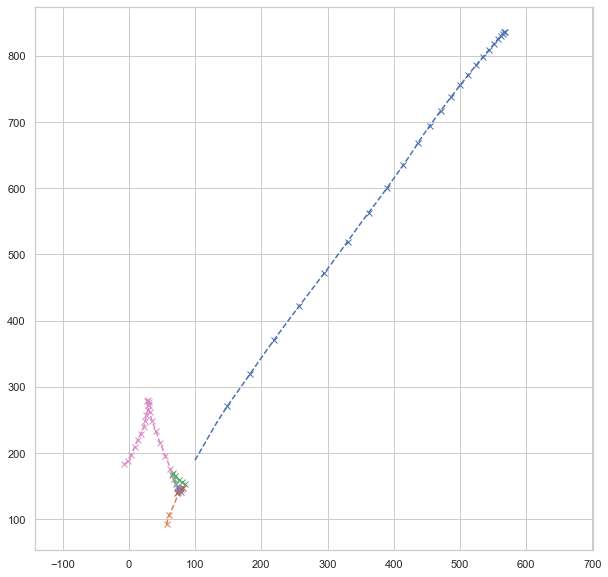

In [58]:
plot_traces(wifi_model, mini_batch_validation)